We developed a model that finds facial expressions (happy, sad, surprise, disgust, neutral, fear, and angry) from image input using a PyTorch package.
In this blog post, we will focus on important technical details of our project.

## 1. Finetuning ResNet, Image Augmentation

Instead of implementing everything from scratch, we decided to finetune ResNet50.<br>
First, we began by writing a class `Resnet`.

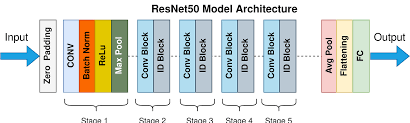

In [ ]:
class Resnet(nn.Module):
    def __init__(self, mode='finetune', pretrained=True):
        """
        use the ResNet50 model from torchvision models.
        
        mode has two options:
        1) linear: For this mode, we want to freeze ResNet50 features, then train a linear
            classifier which takes the features before FC (fully connected layer).
            Replace FC with the one takes in the features and output scores of size 7. (7 expressions)
        2) finetune: Same as 1) linear, except that we do not need to freeze the featues and
            can finetune on the pretrained resnet model.
        """
        self.resnet = models.resnet50(pretrained=Treu)
        
        if mode == 'linear':
            for name, param in self.resnet.named_parameters():
                if param.requires_grad and 'fc' not in name:
                    param.requires_grad = False
            
            num_features = self.resnet.fc.in_features
            self.resnet.fc = nn.Linear(num_features, 7)
            
        elif mode == 'finetune':
            num_features = self.resnet.fc.in_features
            self.resnet.fc = nn.Linear(num_features, 7)
            
    def forward(self, x):
        x = self.resnet(x)
        return x
    
    def to(self, device):
        return self.resnet.to(device=device)

### 1-1. Linear Classifier
First, we started with a linear classifier

In [ ]:
# Define a model, optimizer, and criterion
model = Resnet(mode='linear', pretrained=True)

optimizer = torch.optim.SGD(
    model.parameters()
    lr = 0.005,
    momentum = 0.9
)

criterion = nn.CrossEntropyLoss()

# Define the batch size and number of workers
batch_size = 64
num_workers = 2

train_loader = DataLoader(train_dataset, batch_size, num_workers=num_workers, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size, num_workers=num_workers, shuffle=False)


model_name = "linear1.pt"
try:
    model.load_state_dict(torch.load(PATH + model_name))
    # continue training for more epochs:
    # train(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=5)
except:
    train(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=10)
torch.save(model.state_dict(), PATH + model_name)

After 10 epochs, we were able to get 40.39% validation accuracy.

### 1-2. Fully finetune with same learning rate
Then, we moved to finetuned models. <br>
We began with the learning rate of 0.01

In [ ]:
resnet_finetune1 = Resnet(mode='finetune', pretrained=True)

optimizer = torch.optim.SGD(
    resnet_finetune1.parameters(),
    lr = 0.01,
    momentum = 0.9
)

criterion = nn.CrossEntropyLoss()

### Rest are the same

For the finetuned ResNet50, we got a 61.49% validation accuracy.

### 1-3. Fully finetune with different learning rates
In ResNet50, lower layers typically learn low-level features such as edges and textures that are useful across a wide range of tasks, and therefore may require smaller updates to prevent overfitting. Meanwhile, higher layers may learn more task-specific features that require larger updates to improve performance. <br>

Therefore, we set the learning rate 'fc' layer to 0.01, and 0.001 for the rest.

In [ ]:
resnet_finetune2 = Resnet(mode='finetune', pretrained=True)

last_params, rest_params = [], []
for name, param in resnet_finetune2.named_parameters():
    if 'fc' i nname:
        last_params.append(param)
    else:
        rest_params.append(param)
        
optimizer = torch.optim.SGD(
    [
        {"params": last_params, "lr": 0.01, "momentum": 0.9},
        {"params": rest_params, "lr": 0.001, "momentum": 0.9}
    ]
)

Here, we got a 64.30% validation accuracy.

### 1-4. Finetune with frozen layers
Freezing some layers during fine-tuning can help to prevent overfitting and speed up the training process. When we finetune a pre-trained neural network, we typically want to retain the learned feature representations in the lower layers of the network, which are often more general and transferable across different tasks. By freezing these lower layers, we prevent their weights from being updated during finetuning, which helps to ensure that the model retains its learned feature represenations. This can be particularly important if we have a small amount of data available for the specific task we are finetuning for. <br>

In particular, we set the last fc layer's lr to be 0.01, the first two layers's lrs to be 0, and the rest for 0.001

In [ ]:
last_params, lower_params, rest_params = [], [], []

for name, param in resnet_finetune3.named_parameters():
    if 'fc' in name:
        last_params.append(param)
    elif 'layer1' in name or 'layer2' in name:
        lower_params.append(param)
    else:
        rest_params.append(param)

optimizer = torch.optim.SGD(
    [
        {"params": last_params, "lr": 0.01, "momentum": 0.9},
        {"params": lower_params, "lr": 0, "momentum": 0.9},
        {"params": rest_params, "lr": 0.001, "momentum": 0.9}
    ]
)

Here, we got a 61.66% validation accuracy after 10 epochs.

### 1-5. Image Augmentation
While testing our finetuned models with different learning rates, we observed severe overfittings. To prevent the model learning from the same training data over and over, we used image transformations to 'virtually augment' the dataset. (Instead of adding more images to our dataset, we added the first layer that transforms our images). <br>

We tried different combinations of image transfomations, and we 
decided to use 'horizontal flip', 'random rotation' and 'random perspective' from torchvision.transforms package.

In [1]:
# image transformations
image_hflip = transforms.RandomHorizontalFlip(p=0.2) # p = probability
image_rotate = transforms.RandomRotation((-5, 5)) # degree limits
image_randomP = transforms.RandomPerspective(distortion_scale=0.1, p=0.25)

class Resnet(nn.Module):
    def __init__(self, mode='finetune', augmented=False, pretrained=True):
        super().__init__()
        """
        use the resnet18 model from torchvision models. Remember to set pretrained as true
        
        mode has two options:
        1) linear: For this mode, we want to freeze resnet18 feautres, then train a linear
                    classifier which takes the features before FC (again we do not want the resnet18 FC).
                    And then write our own FC layer: which takes in the features and 
                    output scores of size 7 (since we have 7 categories)
        2) finetune: Same as 1) linear, except that we do not need to freeze the features and
                    can finetune on the pretrained resnet model.
        """
    
            
        self.augmented = augmented
        self.resnet = models.resnet50(pretrained=True)

        if mode == 'linear':
            for name, param in self.resnet.named_parameters():
                if param.requires_grad and 'fc' not in name:
                    param.requires_grad = False
            
            num_features = self.resnet.fc.in_features
            self.resnet.fc = nn.Linear(num_features, 7)

        elif mode == 'finetune':
            num_features = self.resnet.fc.in_features
            self.resnet.fc = nn.Linear(num_features, 7)

    # Here, we added a layer that transforms our images
    def forward(self, x):
        if self.augmented:
            x = image_hflip(x)
            x = image_rotate(x)
            x = image_randomP(x)
        
        x = self.resnet(x)
        return x

    def to(self, device):
        return self.resnet.to(device=device)

We tried this image augmentation with the last two models (different learning rates and the one with frozen layers), and were able to achieve a 65.51% validation accuracy after 20 epochs with the model with different learning rates.